# Importing features and building a baseline model

In the previous notebook, we read and cleaned the [Helen district heat generation dataset](https://www.helen.fi/helen-oy/vastuullisuus/ajankohtaista/avoindata).

Now, we will import some weather data from Finnish Metheorological Institute (FMI) and augment the DH data.

We will build a baseline model, against which all future experiments will be compared.
The baseline model will be a naive linear regression model, with outside temperature as the only predicting variable.
Most likely the ambient temperature will be the most important factor in the end, accounting to a large share of the total variable.

In [1]:
# Add parent folder to path, so that we can import local dh_modelling Python module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
from matplotlib.pyplot import Figure

from dh_modelling.data.prepare_data import FmiData, GenerationData, merge_dataframes

## Data processing and importing

Data importing is now defined in accompanying Python module.
Let's inspect the methdods a bit.

In [2]:
def page_printer(data, start=0, screen_lines=0, pager_cmd=None):
    if isinstance(data, dict):
        data = data['text/plain']
    print(data)

import IPython.core.page
IPython.core.page.page = page_printer

??GenerationData.read_helen

Signature:
GenerationData.read_helen(
    raw_file_path: pathlib.Path = WindowsPath('C:/Users/MikkoKouhia/PERSONAL/helen-dh-generation-modelling/data/raw/hki_dh_2015_2020_a.csv'),
) -> pandas.core.frame.DataFrame
Docstring: <no docstring>
Source:   
    @staticmethod
    def read_helen(
        raw_file_path: Path = raw_data_path / HELEN_DATA_FILENAME,
    ) -> DataFrame:
        logging.info(f"Read Helen generation data, {raw_file_path=}")
        generation_data = GenerationData(raw_file_path=raw_file_path)
        return generation_data.load_and_clean()
File:      c:\users\mikkokouhia\personal\helen-dh-generation-modelling\dh_modelling\data\prepare_data.py
Type:      function



In [3]:
??GenerationData.load_and_clean

Signature: GenerationData.load_and_clean(self) -> pandas.core.frame.DataFrame
Source:   
    def load_and_clean(self) -> DataFrame:
        """
        Load dataframe from disk, clean up features

        :return: Pandas dataframe, with index column 'date_time' and feature column 'dh_MWh'
        """
        logging.info("Load Helen raw dataframe from CSV, clean up file")
        df = pd.read_csv(
            self.raw_file_path,
            sep=";",
            decimal=",",
            parse_dates=["date_time"],
            date_parser=lambda x: datetime.strptime(x, "%d.%m.%Y %H:%M"),
        ).set_index("date_time")
        df.index = df.index.tz_localize(tz="Europe/Helsinki", ambiguous="infer")
        return df
File:      c:\users\mikkokouhia\personal\helen-dh-generation-modelling\dh_modelling\data\prepare_data.py
Type:      function



All in all, the raw generation data is processed as before.

FMI data is read from multiple files, because downloaded file size is limited. The files are still related to one weather station only.

In [4]:
??FmiData.read_fmi

Signature: FmiData.read_fmi(station_name='Kaisaniemi') -> pandas.core.frame.DataFrame
Docstring: <no docstring>
Source:   
    @staticmethod
    def read_fmi(station_name="Kaisaniemi") -> DataFrame:
        logging.info(f"Read FMI data, {station_name=}")
        fmi_data = FmiData(
            *[(raw_data_path / i) for i in fmi_weather_files[station_name]]
        )
        return fmi_data.load_and_clean()
File:      c:\users\mikkokouhia\personal\helen-dh-generation-modelling\dh_modelling\data\prepare_data.py
Type:      function



In [5]:
??FmiData.load_and_clean

Signature: FmiData.load_and_clean(self) -> pandas.core.frame.DataFrame
Source:   
    def load_and_clean(self) -> DataFrame:
        """
        Load data files from disk, clean up features
        :return: Pandas dataframe, with index column 'datetime'
        """
        logging.info("Load and clean up data files")
        frames = [self.read_file(f) for f in self.raw_file_paths]
        df = concat(frames)
        df = df.loc[~df.index.duplicated()]

        df["Ilman lämpötila (degC)"].interpolate(inplace=True)

        return df
File:      c:\users\mikkokouhia\personal\helen-dh-generation-modelling\dh_modelling\data\prepare_data.py
Type:      function



While loading weather data, some missing values in the ambient temperature are interpolated from their nearest neighbours.

In [6]:
??merge_dataframes

Signature:
merge_dataframes(
    df_helen: pandas.core.frame.DataFrame,
    df_fmi: pandas.core.frame.DataFrame,
) -> pandas.core.frame.DataFrame
Docstring: <no docstring>
Source:   
def merge_dataframes(df_helen: DataFrame, df_fmi: DataFrame) -> DataFrame:
    return merge(df_helen, df_fmi, how="left", left_index=True, right_index=True)
File:      c:\users\mikkokouhia\personal\helen-dh-generation-modelling\dh_modelling\data\prepare_data.py
Type:      function



In [7]:
df_weather = FmiData.read_fmi()
df_generation = GenerationData.read_helen()
df: pd.DataFrame = merge_dataframes(df_helen=df_generation, df_fmi=df_weather)
df

,dh_MWh,Pilvien määrä (1/8),Ilmanpaine (msl) (hPa),Sademäärä (mm),Suhteellinen kosteus (%),Sateen intensiteetti (mm/h),Lumensyvyys (cm),Ilman lämpötila (degC),Kastepistelämpötila (degC),Näkyvyys (m),Tuulen suunta (deg),Puuskanopeus (m/s),Tuulen nopeus (m/s)
date_time,,,,,,,,,,,,,
2015-01-01 01:00:00+02:00,936.000,8.0,1010.6,0.0,94.0,0.0,4.0,4.0,3.1,NaN,282.0,6.2,4.2
2015-01-01 02:00:00+02:00,924.200,7.0,1010.6,0.0,93.0,0.0,4.0,4.1,3.1,NaN,290.0,6.1,3.7
2015-01-01 03:00:00+02:00,926.300,7.0,1010.5,0.0,93.0,0.0,4.0,4.2,3.1,NaN,284.0,6.6,3.4
2015-01-01 04:00:00+02:00,942.100,3.0,1010.5,0.0,94.0,0.0,4.0,3.6,2.8,NaN,285.0,6.2,3.3
2015-01-01 05:00:00+02:00,957.100,7.0,1010.1,0.0,96.0,0.0,4.0,3.3,2.8,NaN,282.0,4.9,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00+02:00,1191.663,7.0,1007.4,0.2,98.0,0.4,0.0,1.7,1.4,5100.0,0.0,0.0,0.0
2020-12-31 20:00:00+02:00,1155.601,7.0,1007.9,0.3,98.0,0.0,0.0,1.5,1.3,3480.0,248.0,2.2,1.6
2020-12-31 21:00:00+02:00,1149.378,7.0,1008.4,0.6,96.0,0.5,0.0,1.5,0.9,6020.0,235.0,3.3,2.4


Let's plot these variables in a scatter plot

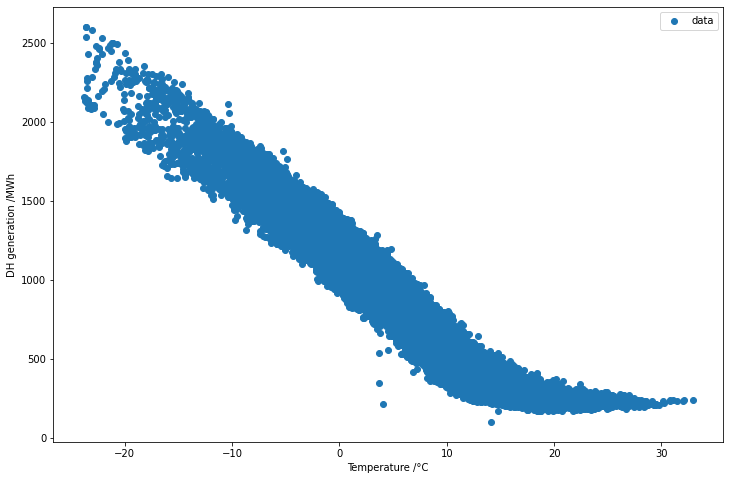

In [8]:
%matplotlib inline

fig = Figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(x=df['Ilman lämpötila (degC)'], y=df['dh_MWh'], label='data')

ax.set_xlabel("Temperature /°C")
ax.set_ylabel("DH generation /MWh")
ax.legend()
fig

It very much seems that we can get a decent approximation for DH consumption from ambient temperature,
as a basis for a baseline model.

## Baseline model generation

Now we will generate a naive model, which acts as baseline when comparing other models

### Linear model from ambient temperature

In [9]:
import numpy as np
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(df[['Ilman lämpötila (degC)']], df['dh_MWh'])

temps = np.linspace(-22, 30)
preds = lm.predict(temps.reshape(-1, 1))

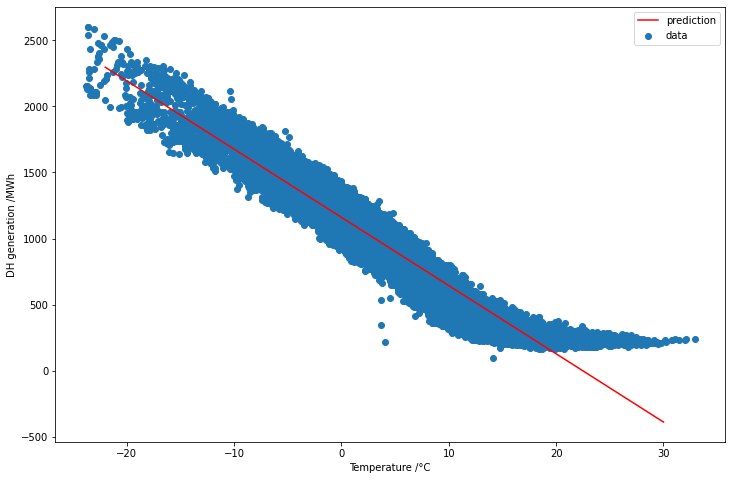

In [10]:
ax.plot(temps, preds, color='r', label='prediction')
ax.legend()
fig

In [11]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

all_pred = lm.predict(df[['Ilman lämpötila (degC)']])
metrics = dict()
metrics['mean_absolute_error'] = mean_absolute_error(df['dh_MWh'], all_pred)
metrics['mean_absolute_percentage_error'] = mean_absolute_percentage_error(df['dh_MWh'], all_pred)
metrics['root_mean_squared_error'] = mean_squared_error(df['dh_MWh'], all_pred, squared=False)
metrics

{'mean_absolute_error': 95.57254508990161,
 'mean_absolute_percentage_error': 0.1932716326216985,
 'root_mean_squared_error': 119.8176468001108}

We can see easily that a linear model fails to take into account base load and the temperature-dependent part.
Housing heat demand is usually removed at about 17 degrees, let's implement a piecewise linear model

### Piecewise linear model from ambient temperature

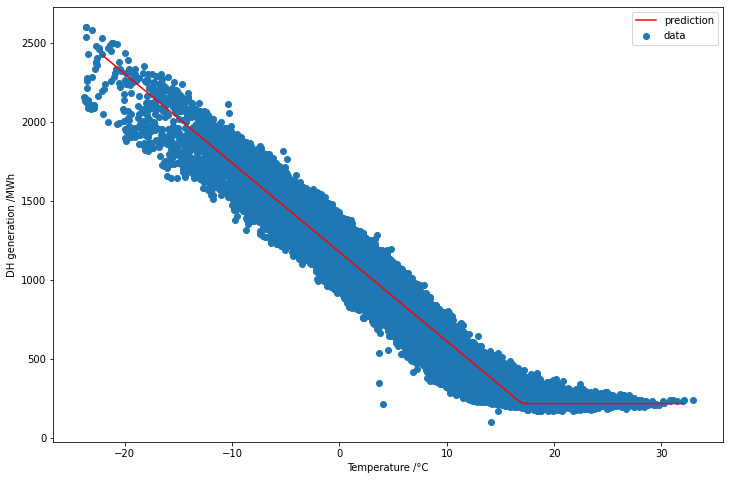

In [12]:
%matplotlib inline 

from scipy import optimize

def piecewise_linear(x, y0, k1):
    x0=17
    k2=0
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p, e = optimize.curve_fit(piecewise_linear, df['Ilman lämpötila (degC)'].to_numpy(), df['dh_MWh'].to_numpy())
xd = np.linspace(-22, 32, 100)

fig2 = Figure(figsize=(12,8))
ax2 = fig2.add_subplot(111)
ax2.scatter(x=df['Ilman lämpötila (degC)'], y=df['dh_MWh'], label='data')
ax2.plot(xd, piecewise_linear(xd, *p), label= 'prediction', color='r')

ax2.set_xlabel("Temperature /°C")
ax2.set_ylabel("DH generation /MWh")
ax2.legend()
fig2

In [13]:
pwl_pred_all = piecewise_linear(df['Ilman lämpötila (degC)'].to_numpy(), *p)

metrics = dict()
metrics['mean_absolute_error'] = mean_absolute_error(df['dh_MWh'], pwl_pred_all)
metrics['mean_absolute_percentage_error'] = mean_absolute_percentage_error(df['dh_MWh'], pwl_pred_all)
metrics['root_mean_squared_error'] = mean_squared_error(df['dh_MWh'], pwl_pred_all, squared=False)
metrics

{'mean_absolute_error': 77.44964632920185,
 'mean_absolute_percentage_error': 0.12434261513640625,
 'root_mean_squared_error': 97.4262645425964}

This will serve as our baseline model. Let's plot predictions and actual values for a sample period

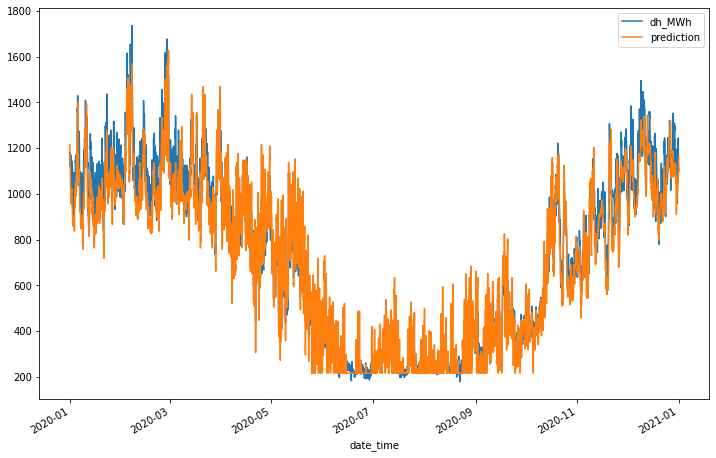

In [14]:
df['prediction'] = pwl_pred_all
fig3x = Figure(figsize=(12,8))
ax3x = fig3x.add_subplot(1,1,1)
df.loc[(df.index > '2020-01-01'), ['dh_MWh', 'prediction']].plot(ax=ax3x)

fig3x

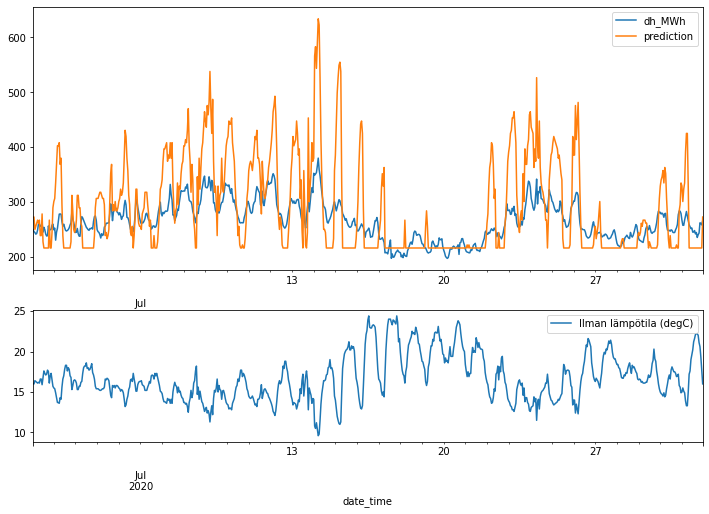

In [15]:
from matplotlib.gridspec import GridSpec

df['prediction'] = pwl_pred_all
fig3 = Figure(figsize=(12,8))
spec = GridSpec(ncols=1, nrows=2, height_ratios=[2, 1])
ax31 = fig3.add_subplot(spec[0])
ax32 = fig3.add_subplot(spec[1])
df.loc[((df.index > '2020-07-01') & (df.index < '2020-08-01')), ['dh_MWh', 'prediction']].plot(ax=ax31)
df.loc[((df.index > '2020-07-01') & (df.index < '2020-08-01')), ['Ilman lämpötila (degC)']].plot(ax=ax32)

fig3

The PWL estimation overestimates the heat demand during summer months. Let's investigate the generation for a colder period.

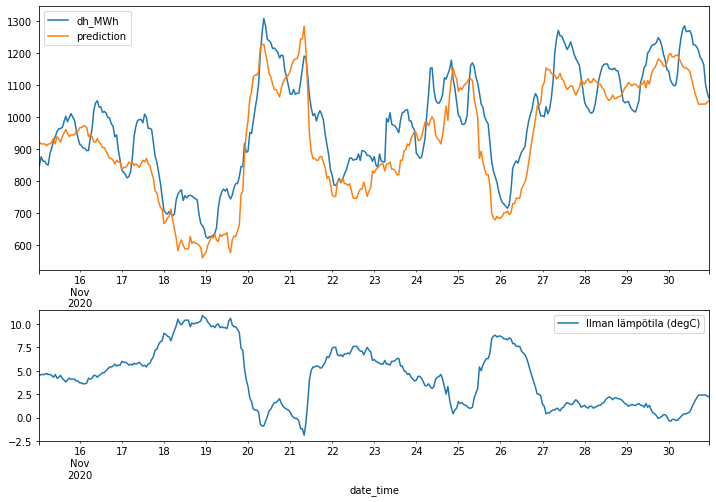

In [16]:
%matplotlib inline 

fig4 = Figure(figsize=(12,8))
spec = GridSpec(ncols=1, nrows=2, height_ratios=[2, 1])
ax41 = fig4.add_subplot(spec[0])
ax42 = fig4.add_subplot(spec[1])
df.loc[((df.index > '2020-11-15') & (df.index < '2020-12-01')), ['dh_MWh', 'prediction']].plot(ax=ax41)
df.loc[((df.index > '2020-11-15') & (df.index < '2020-12-01')), ['Ilman lämpötila (degC)']].plot(ax=ax42)

fig4

This is somewhat better. Later we will investigate other models against this baseline.